# Data Science I Project

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import scipy.stats as stats


## Utils

In [67]:
def create_frequency_table_with_credit_risk(index: str, df: pd.DataFrame):
    cross_table_credit_hist = pd.crosstab(df[index], df["CreditRiskClass"], margins=True)
    cross_table_credit_hist[f"P(Bad|{index})"] = cross_table_credit_hist["Bad"]/cross_table_credit_hist["All"]
    cross_table_credit_hist[f"P(Good|{index})"] = 1 - cross_table_credit_hist[f"P(Bad|{index})"]
    return cross_table_credit_hist

def detect_rare_nominal_categories(dataset_df: pd.DataFrame, threshold: int):
    categorical_cols = dataset_df.select_dtypes("object").columns
    
    for col_name in categorical_cols:
        rel_freq_s = dataset_df[col_name].value_counts(normalize=True)*100
        
        below_threshold = rel_freq_s[rel_freq_s < threshold].index.to_list()
        
        if (len(below_threshold)): 
            print(f"\n Categories in Feature {col_name} below threshold freq: {below_threshold}")
            print("Relative Frequency: ")
            print(rel_freq_s)

def merge_categories(dataset_df: pd.DataFrame, feature: str, categories_to_merge: list, merged_category_name: str):
    dataset_df[feature] = dataset_df[feature].apply(lambda value: merged_category_name if value in categories_to_merge else value)
    return dataset_df

def detect_rare_ordinal_categories(dataset_df: pd.DataFrame, threshold: int):
    numerical_cols = dataset_df.select_dtypes("int64")
    
    col_unique_counts_s = numerical_cols.nunique()
    
    ordinal_cols = col_unique_counts_s[col_unique_counts_s < 8].index
    
    for col_name in ordinal_cols:
        rel_freq_s = dataset_df[col_name].value_counts(normalize=True)*100
        
        below_threshold = rel_freq_s[rel_freq_s < threshold].index.to_list()
        
        if (len(below_threshold)): 
            print(f"\n Categories in Feature {col_name} below threshold freq: {below_threshold}")
            print("Relative Frequency: ")
            print(rel_freq_s)
            
from sklearn.metrics import confusion_matrix

# Custom cost function
def cost_metric(y_true, y_pred):
    cost_matrix = cost_matrix = np.array([[0, 1], [5, 0]])
    cm = confusion_matrix(y_true, y_pred)
    return int(np.sum(cm * cost_matrix))

def break_label(label, max_length=18):
    words = label.split()
    new_label = []
    current_line = ""
    
    for word in words:
        if len(current_line) + len(word) + 1 > max_length:
            new_label.append(current_line)
            current_line = word
        else:
            if current_line:
                current_line += ' '
            current_line += word
    new_label.append(current_line)
    
    return '\n'.join(new_label)

## Loading Dataset

In [68]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144)

In [69]:
statlog_german_credit_data.data.original

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,...,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,...,A121,31,A143,A152,1,A172,1,A191,A201,1
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,...,A122,40,A143,A152,1,A174,1,A192,A201,1
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,...,A123,38,A143,A152,1,A173,1,A191,A201,1
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,...,A124,23,A143,A153,1,A173,1,A192,A201,2


In [70]:
metadata = statlog_german_credit_data.metadata

print("Abstract: ", metadata["abstract"])
print("Area: ", metadata["area"])
print("Number of Instances: ", metadata["num_instances"])
print("Has Missing Values: ", metadata["has_missing_values"])
print("Number of Features: ", metadata["num_features"])
print("Feature Types: ", metadata["feature_types"])
print("Demographics: ", metadata["demographics"])

Abstract:  This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix
Area:  Social Science
Number of Instances:  1000
Has Missing Values:  no
Number of Features:  20
Feature Types:  ['Categorical', 'Integer']
Demographics:  ['Other', 'Marital Status', 'Age', 'Occupation']


In [71]:
statlog_german_credit_data.variables

,name,role,type,demographic,description,units,missing_values
0,Attribute1,Feature,Categorical,None,Status of existing checking account,None,no
1,Attribute2,Feature,Integer,None,Duration,months,no
2,Attribute3,Feature,Categorical,None,Credit history,None,no
3,Attribute4,Feature,Categorical,None,Purpose,None,no
4,Attribute5,Feature,Integer,None,Credit amount,None,no
5,Attribute6,Feature,Categorical,None,Savings account/bonds,None,no
6,Attribute7,Feature,Categorical,Other,Present employment since,None,no
7,Attribute8,Feature,Integer,None,Installment rate in percentage of disposable i...,None,no
8,Attribute9,Feature,Categorical,Marital Status,Personal status and sex,None,no
9,Attribute10,Feature,Categorical,None,Other debtors / guarantors,None,no


## Data Pre-processing (with some EDA)

In this part, the categorical features will be transformed into easier understandable data, so that the EDA can be performed.

Besides, as there are many categories inside some features, some categories will be joined to facilitate the EDA

In [72]:
dataset_df = statlog_german_credit_data.data.original

COLUMN_RENAME_DICT = {
    'Attribute1': 'CheckingAccountStatus',
    'Attribute2': 'DurationInMonths',
    'Attribute3': 'CreditHistory',
    'Attribute4': 'Purpose',
    'Attribute5': 'CreditAmount',
    'Attribute6': 'SavingsAccountBonds',
    'Attribute7': 'EmploymentSince',
    'Attribute8': 'InstallmentRate',
    'Attribute9': 'PersonalStatusSex',
    'Attribute10': 'OtherDebtorsGuarantors',
    'Attribute11': 'ResidenceSince',
    'Attribute12': 'Property',
    'Attribute13': 'Age',
    'Attribute14': 'OtherInstallmentPlans',
    'Attribute15': 'Housing',
    'Attribute16': 'ExistingCreditsCount',
    'Attribute17': 'Job',
    'Attribute18': 'PeopleLiableMaintenance',
    'Attribute19': 'Telephone',
    'Attribute20': 'ForeignWorker',
    'class': 'CreditRiskClass'
}

dataset_df = dataset_df.rename(columns = COLUMN_RENAME_DICT)


Below, the mappings for the categorical data are defined

In [73]:
# Consolidated mapping dictionary for all categorical columns
categorical_mappings = {
    'CheckingAccountStatus': {
        'A11': 'Less than 0 DM',
        'A12': '0 to 200 DM',
        'A13': '200 DM or more',
        'A14': 'No checking account'
    },
    'CreditHistory': {
        'A30': 'No credits taken', # individual has never taken out any credits
        'A31': 'All credits at this bank paid back duly', # individual has taken out credits from this particular bank and has paid them all back on time
        'A32': 'Existing credits paid back duly till now', # individual currently has existing credits and has been paying them back on time up to the present moment.
        'A33': 'Delay in paying off in the past', # individual has experienced delays in making credit payments in the past
        'A34': 'Critical account / other credits existing'
    },
    'Purpose': {
        'A40': 'Car (new)',
        'A41': 'Car (used)',
        'A42': 'Furniture/equipment',
        'A43': 'Radio/television',
        'A44': 'Domestic appliances',
        'A45': 'Repairs',
        'A46': 'Education',
        'A47': 'Vacation',
        'A48': 'Retraining',
        'A49': 'Business',
        'A410': 'Others'
    },
    'SavingsAccountBonds': {
        'A61': 'Less than 100 DM',
        'A62': '100 to 500 DM',
        'A63': '500 to 1000 DM',
        'A64': '1000 DM or more',
        'A65': 'Unknown / no savings account'
    },
    'EmploymentSince': {
        'A71': 'Unemployed',
        'A72': 'Less than 1 year',
        'A73': '1 to 4 years',
        'A74': '4 to 7 years',
        'A75': '7 years or more'
    },
    'PersonalStatusSex': {
        'A91': 'Male: divorced',
        'A92': 'Female: divorced/married',
        'A93': 'Male: single',
        'A94': 'Male: married/widowed',
        'A95': 'Female: single'
    },
    'OtherDebtorsGuarantors': {
        'A101': 'None',
        'A102': 'Co-applicant',
        'A103': 'Guarantor'
    },
    'Property': {
        'A121': 'Real estate',
        'A122': 'Building society savings agreement / life insurance',
        'A123': 'Car or other',
        'A124': 'Unknown / no property'
    },
    'OtherInstallmentPlans': {
        'A141': 'Bank',
        'A142': 'Stores',
        'A143': 'None'
    },
    'Housing': {
        'A151': 'Rent',
        'A152': 'Own',
        'A153': 'For free'
    },
    'Job': {
        'A171': 'Unemployed / unskilled - non-resident',
        'A172': 'Unskilled - resident',
        'A173': 'Skilled employee / official',
        'A174': 'Management / self-employed / highly qualified employee / officer'
    },
    'Telephone': {
        'A191': 'No',
        'A192': 'Yes'
    },
    'ForeignWorker': {
        'A201': 'Yes',
        'A202': 'No'
    }
}

In [74]:
# replacing codes with descriptive labels using the consolidated mappings
for column, mapping in categorical_mappings.items():
    dataset_df[column] = dataset_df[column].replace(mapping)

# Replace values of the target variable, as defined in the instructions of the dataset 
dataset_df["CreditRiskClass"] = dataset_df["CreditRiskClass"].replace(1,0) # Good payer, low risk
dataset_df["CreditRiskClass"] = dataset_df["CreditRiskClass"].replace(2,1) # Bad payer. high risk
credit_risk_class_map = ["Good", "Bad"]
dataset_df["CreditRiskClass"] = dataset_df["CreditRiskClass"].apply(lambda risk_class: credit_risk_class_map[risk_class])

In the next part, categories that have a low frequency of samples in the dataset in some features will be joined to facilitate the EDA. This will also already help by avoiding overfitting and reducing the dimensionality of the dataset.

In [75]:
detect_rare_nominal_categories(dataset_df, 6)


 Categories in Feature CreditHistory below threshold freq: ['All credits at this bank paid back duly', 'No credits taken']
Relative Frequency: 
CreditHistory
Existing credits paid back duly till now     53.0
Critical account / other credits existing    29.3
Delay in paying off in the past               8.8
All credits at this bank paid back duly       4.9
No credits taken                              4.0
Name: proportion, dtype: float64

 Categories in Feature Purpose below threshold freq: ['Education', 'Repairs', 'Domestic appliances', 'Others', 'Retraining']
Relative Frequency: 
Purpose
Radio/television       28.0
Car (new)              23.4
Furniture/equipment    18.1
Car (used)             10.3
Business                9.7
Education               5.0
Repairs                 2.2
Domestic appliances     1.2
Others                  1.2
Retraining              0.9
Name: proportion, dtype: float64

 Categories in Feature SavingsAccountBonds below threshold freq: ['1000 DM or more']
Rela

In [76]:
# Rare nominal categories are merged to reduce complexity and avoid overfitting

dataset_df = merge_categories(dataset_df, feature="CreditHistory",
                 categories_to_merge=["All credits at this bank paid back duly", "No credits taken"],
                 merged_category_name="No credits taken or all credits paid back duly")

dataset_df = merge_categories(dataset_df, feature="Purpose",
                 categories_to_merge=["Retraining", "Domestic appliances", "Repairs", "Education"],
                 merged_category_name="Others")

dataset_df = merge_categories(dataset_df, feature="SavingsAccountBonds",
                              categories_to_merge=["500 to 1000 DM", "1000 DM or more"],
                              merged_category_name="500 DM or more")

dataset_df = merge_categories(dataset_df, feature="PersonalStatusSex",
                              categories_to_merge=["Male: divorced", "Male: single"],
                              merged_category_name="Male: divorced/single")
dataset_df["PersonalStatusSex"] = dataset_df["PersonalStatusSex"].replace("Female: divorced/married", "Female")

dataset_df = merge_categories(dataset_df, feature="OtherDebtorsGuarantors",
                 categories_to_merge=["Guarantor", "Co-applicant"],
                 merged_category_name="Yes")
dataset_df["OtherDebtorsGuarantors"] = dataset_df["OtherDebtorsGuarantors"].replace("None", "No")

dataset_df = merge_categories(dataset_df, feature="OtherInstallmentPlans",
                 categories_to_merge=["Bank", "Stores"],
                 merged_category_name="Yes")
dataset_df["OtherInstallmentPlans"] = dataset_df["OtherInstallmentPlans"].replace("None", "No")

dataset_df = merge_categories(dataset_df, feature="Job",
                 categories_to_merge=["Unskilled - resident", "Unemployed / unskilled - non-resident"],
                 merged_category_name="Unemployed/Unskilled")
dataset_df["OtherInstallmentPlans"] = dataset_df["OtherInstallmentPlans"].replace("None", "No")


**Observation**

Only only 37 samples out of 1000 have the ForeignWorker = 1. Such low number of samples is most likely to lead to overfitting. Therefore, this feature is dropped.

In [77]:
dataset_df = dataset_df.drop(columns=["ForeignWorker"])

In [78]:
detect_rare_ordinal_categories(dataset_df, 5)


 Categories in Feature ExistingCreditsCount below threshold freq: [3, 4]
Relative Frequency: 
ExistingCreditsCount
1    63.3
2    33.3
3     2.8
4     0.6
Name: proportion, dtype: float64


In [79]:
merge_categories(dataset_df, feature="ExistingCreditsCount",
                 categories_to_merge=[3, 4],
                 merged_category_name="More than 1")
dataset_df["ExistingCreditsCount"] = dataset_df["ExistingCreditsCount"].replace(2, "More than 1")
dataset_df["ExistingCreditsCount"] = dataset_df["ExistingCreditsCount"].replace(1, "1")

## EDA


In [80]:
dataset_df.head(6)

,CheckingAccountStatus,DurationInMonths,CreditHistory,Purpose,CreditAmount,SavingsAccountBonds,EmploymentSince,InstallmentRate,PersonalStatusSex,OtherDebtorsGuarantors,ResidenceSince,Property,Age,OtherInstallmentPlans,Housing,ExistingCreditsCount,Job,PeopleLiableMaintenance,Telephone,CreditRiskClass
0,Less than 0 DM,6,Critical account / other credits existing,Radio/television,1169,Unknown / no savings account,7 years or more,4,Male: divorced/single,No,4,Real estate,67,No,Own,More than 1,Skilled employee / official,1,Yes,Good
1,0 to 200 DM,48,Existing credits paid back duly till now,Radio/television,5951,Less than 100 DM,1 to 4 years,2,Female,No,2,Real estate,22,No,Own,1,Skilled employee / official,1,No,Bad
2,No checking account,12,Critical account / other credits existing,Others,2096,Less than 100 DM,4 to 7 years,2,Male: divorced/single,No,3,Real estate,49,No,Own,1,Unemployed/Unskilled,2,No,Good
3,Less than 0 DM,42,Existing credits paid back duly till now,Furniture/equipment,7882,Less than 100 DM,4 to 7 years,2,Male: divorced/single,Yes,4,Building society savings agreement / life insu...,45,No,For free,1,Skilled employee / official,2,No,Good
4,Less than 0 DM,24,Delay in paying off in the past,Car (new),4870,Less than 100 DM,1 to 4 years,3,Male: divorced/single,No,4,Unknown / no property,53,No,For free,More than 1,Skilled employee / official,2,No,Bad
5,No checking account,36,Existing credits paid back duly till now,Others,9055,Unknown / no savings account,1 to 4 years,2,Male: divorced/single,No,4,Unknown / no property,35,No,For free,1,Unemployed/Unskilled,2,Yes,Good


In [81]:
print(dataset_df.describe())

       DurationInMonths  CreditAmount  InstallmentRate  ResidenceSince  \
count       1000.000000   1000.000000      1000.000000     1000.000000   
mean          20.903000   3271.258000         2.973000        2.845000   
std           12.058814   2822.736876         1.118715        1.103718   
min            4.000000    250.000000         1.000000        1.000000   
25%           12.000000   1365.500000         2.000000        2.000000   
50%           18.000000   2319.500000         3.000000        3.000000   
75%           24.000000   3972.250000         4.000000        4.000000   
max           72.000000  18424.000000         4.000000        4.000000   

               Age  PeopleLiableMaintenance  
count  1000.000000              1000.000000  
mean     35.546000                 1.155000  
std      11.375469                 0.362086  
min      19.000000                 1.000000  
25%      27.000000                 1.000000  
50%      33.000000                 1.000000  
75%      42

**Analysis**

The maximum and minimum values of all numerical features are reasonable. There are no outlier values that could have been generated by human error.

In [82]:
print(dataset_df.info())
number_samples = len(dataset_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   CheckingAccountStatus    1000 non-null   object
 1   DurationInMonths         1000 non-null   int64 
 2   CreditHistory            1000 non-null   object
 3   Purpose                  1000 non-null   object
 4   CreditAmount             1000 non-null   int64 
 5   SavingsAccountBonds      1000 non-null   object
 6   EmploymentSince          1000 non-null   object
 7   InstallmentRate          1000 non-null   int64 
 8   PersonalStatusSex        1000 non-null   object
 9   OtherDebtorsGuarantors   1000 non-null   object
 10  ResidenceSince           1000 non-null   int64 
 11  Property                 1000 non-null   object
 12  Age                      1000 non-null   int64 
 13  OtherInstallmentPlans    1000 non-null   object
 14  Housing                  1000 non-null   

Most features are categorical (type 'object'). Some numerical features (type 'int64'), such as PeopleLiableMaintenance, can also be ordinal.

CreditRiskClass
Good    0.7
Bad     0.3
Name: count, dtype: float64

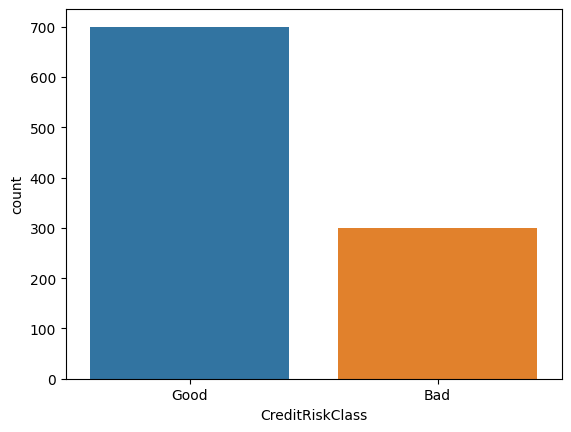

In [83]:
sns.countplot(x="CreditRiskClass", data=dataset_df, hue="CreditRiskClass")
dataset_df["CreditRiskClass"].value_counts()/number_samples

**Analysis**

The dataset is highly unbalanced between the classes "Good payers" and "Bad payers"

### Analysis of Numerical Features

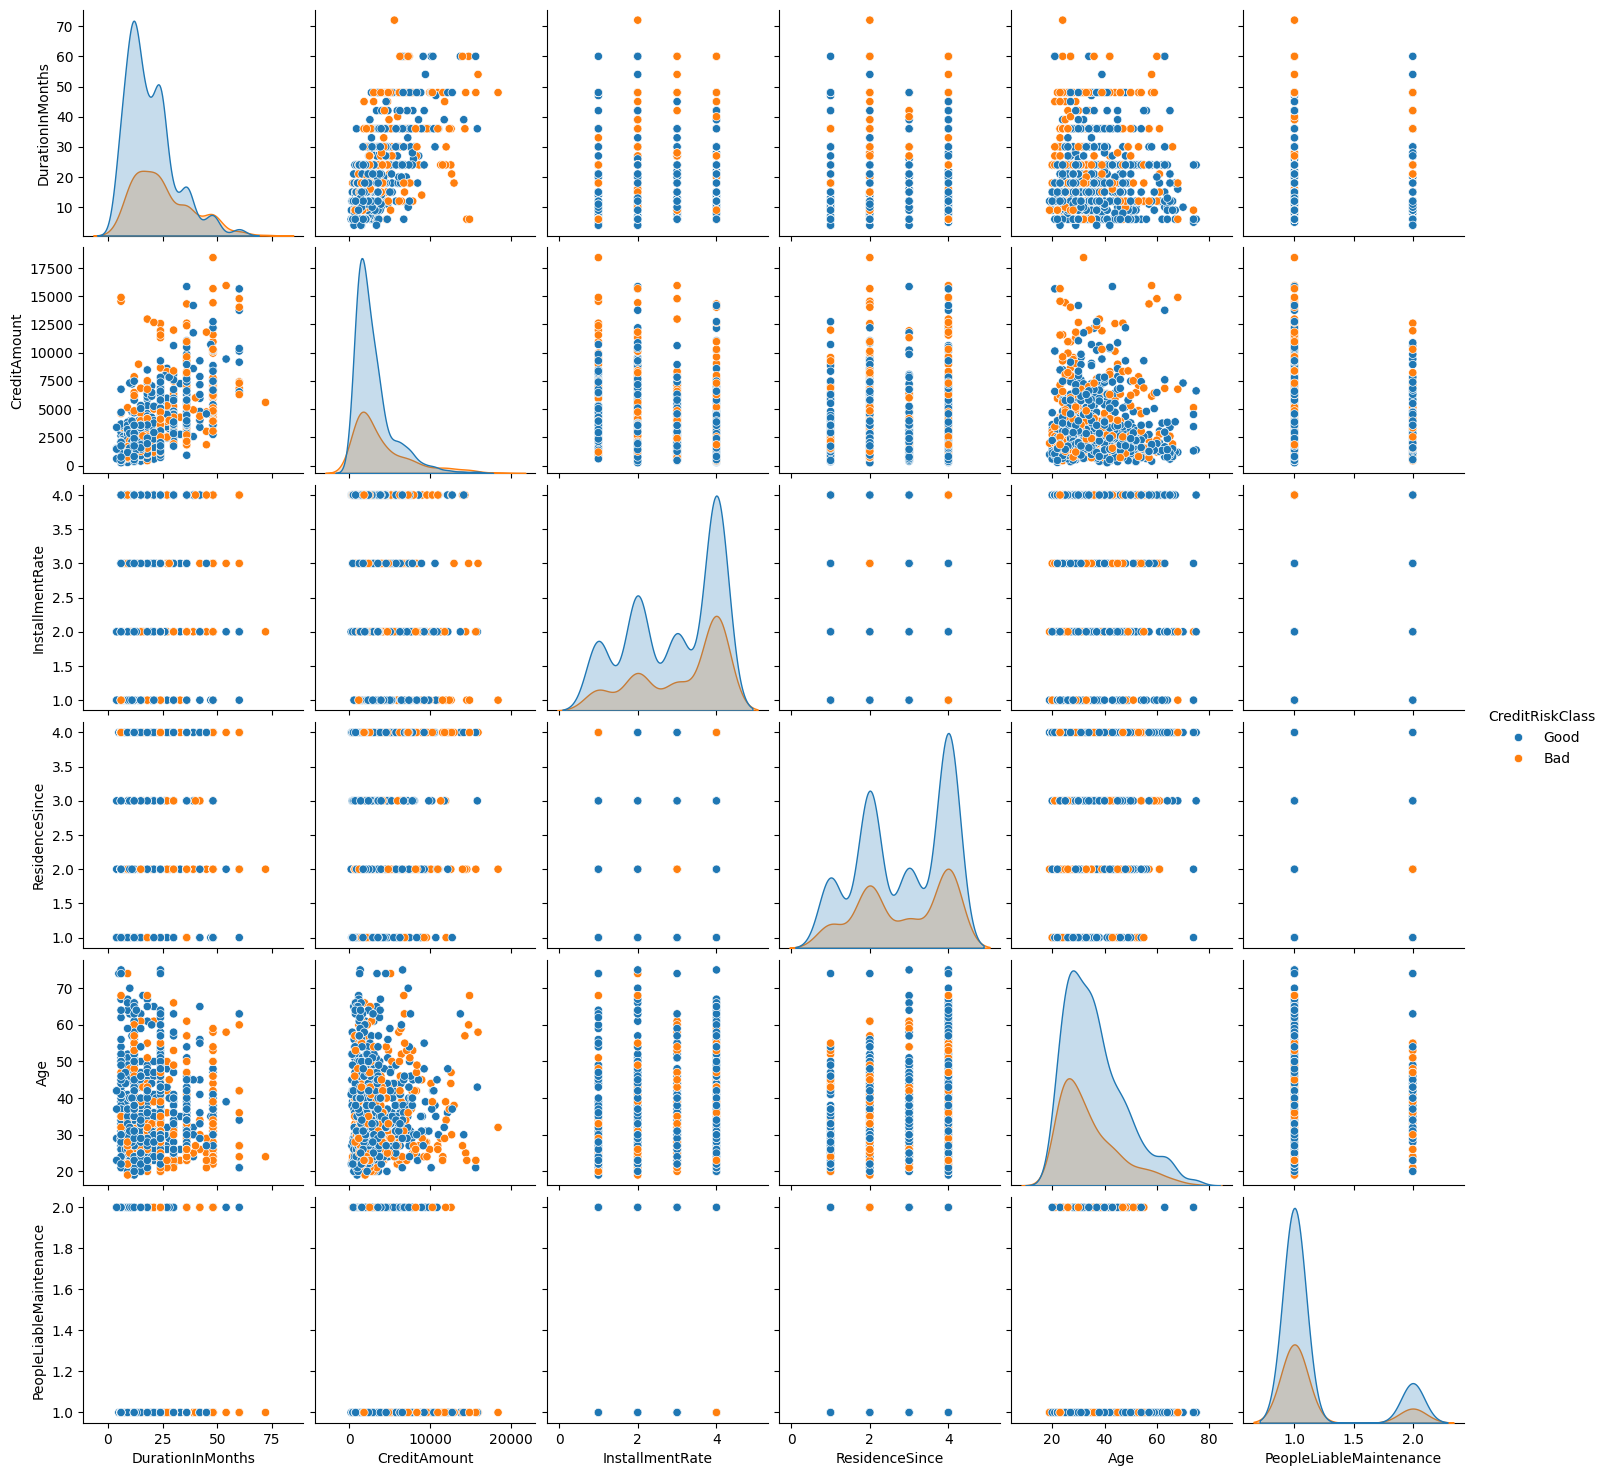

In [84]:
sns.pairplot(dataset_df, hue="CreditRiskClass")

**Analysis**

1. Univariate distributions:
Observing the diagonal, no features can clearly separate the two classes, what makes the classification task harder. The univariate distributions for both classes are general very similar. Apparently, the features "CreditAmount" and "DurationInMonths" are the ones how gives a higher difference in the distribution format.

2. DurationInMonths and CreditAmount:
In the features 'DurationInMonths' and 'CreditAmount', the distributions for each target class show a positive skewness (the mean is higher than the mode). In the target class "bad payers" however, the skewness seems to be higher (mean is further away from the mode). Besides, in the joint scatter plot DurationInMonths-CreditAmount, the concentration of "bad payers" is also higher for higher values of 
CreditAmount.

3. Other Numerical Features:
It is possible to note that all numerical feature except for "Age", "DurationInMonths" and "CreditAmount" have only few discrete possible values such as "1, 2, 3, ...". In this case, a "Spearman" correlation measure is more suitable for correlation analysis, as shown below. Besides, **they can also be treated as "ordinal variables", although they are numeric**

C:\Users\User\AppData\Local\Temp\ipykernel_22060\2364235743.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numerical_features["CreditRisk"] = dataset_df["CreditRiskClass"].replace(to_replace={"Good": 0, "Bad": 1})


<Axes: >

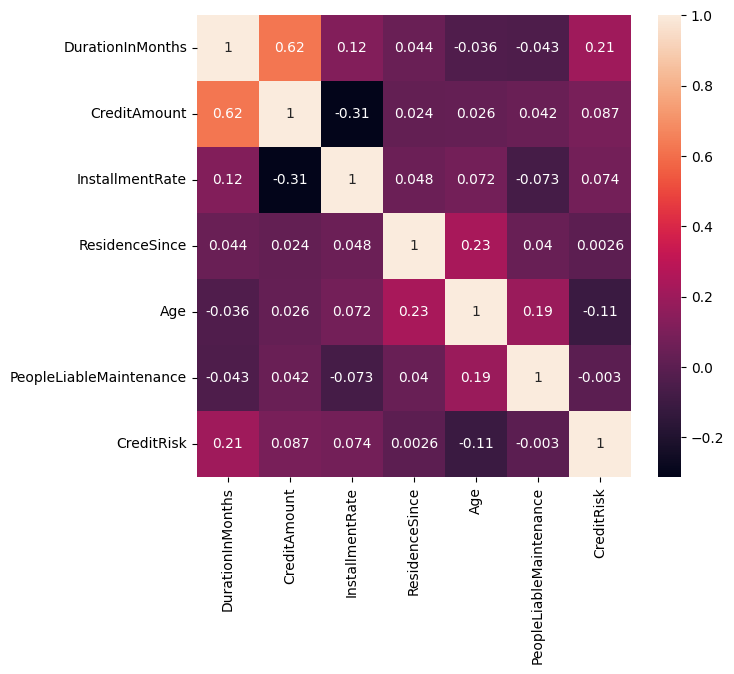

In [85]:
numerical_features = dataset_df.select_dtypes(include=["int64", "float64"])
numerical_features["CreditRisk"] = dataset_df["CreditRiskClass"].replace(to_replace={"Good": 0, "Bad": 1})

plt.figure(figsize=(7, 6))
sns.heatmap(data=numerical_features.corr(method='spearman'), annot=True)

**Analysis**

In the heatmap above, it is possible to see that the DurationInMonths and CreditAmount are the features with the highest correlation in absolute value, followed by "InstallmentRate-CreditAmount", "ResidenceSince-Age" and "PeopleLiableMaintenance-Age".

What regards ranked correlation with the credit risk, with "0" denoting low risk (good payer) and "1" denoting high risk (bad payer), we can see that no feature has a high correlation in absolute value. The highest ones are "DurationInMonths", "Age", "Credit Amount", "InstallmentRate". The highest one (DurationInMonths) has only "-0.27". This also makes the classification task more challenging. Apparently, there are no strong linear relations in the dataset.

The low correlation in many variables (such as PeopleLiableMaintenance or ResidenceSince) can indicate that the target variable "CreditRisk" may actually not be dependent of them (they may not be usefull for prediction task). Therefore, a dependence hypothesis test over such variable is relevant to attest this and possibly discard such variables from the analysis/prediction task.

Text(0, 0.5, '')

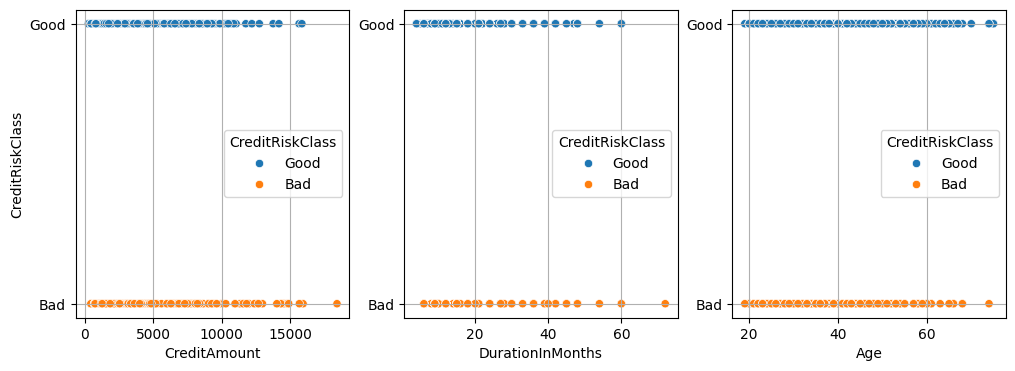

In [86]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.scatterplot(ax=axes[0], x="CreditAmount", y="CreditRiskClass", data=dataset_df, hue="CreditRiskClass", hue_order=["Good", "Bad"])
axes[0].grid()

sns.scatterplot(ax=axes[1], x="DurationInMonths", y="CreditRiskClass", data=dataset_df, hue="CreditRiskClass", hue_order=["Good", "Bad"])
axes[1].grid()
axes[1].set_ylabel("")

sns.scatterplot(ax=axes[2], x="Age", y="CreditRiskClass", data=dataset_df, hue="CreditRiskClass", hue_order=["Good", "Bad"])
axes[2].grid()
axes[2].set_ylabel("")

**Analysis**

As it can be observed above, there is no clear linear relation between the most correlated variables and the target variable. It would be hard, for example, to fit a logistic function in the plots above.

<Figure size 1600x400 with 0 Axes>

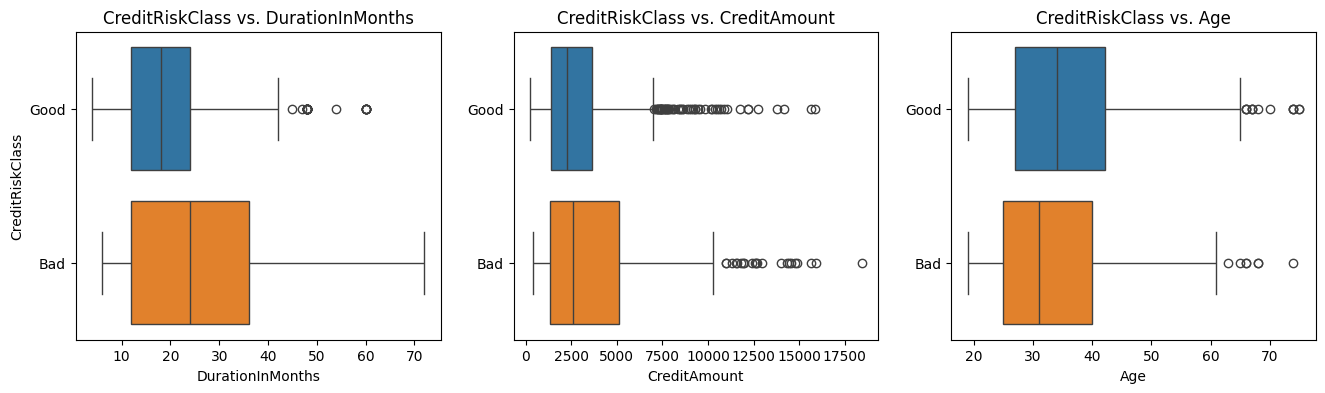

In [87]:
plt.figure(figsize=(16, 4))
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

# Plotting CreditRiskClass against significant numerical features
for index, feature in enumerate(["DurationInMonths", "CreditAmount", "Age"]):
    ax = axes[index]
    sns.boxplot(ax=ax, y='CreditRiskClass', x=feature, data=dataset_df, hue="CreditRiskClass", hue_order=["Good", "Bad"])
    if (index != 0): ax.set_ylabel("")
    ax.set_title(f'CreditRiskClass vs. {feature}')

plt.show()

**Analysis**

As indicated by the pair plot previously, the means of the numerical features "DurationINMonths" and "CreditAmount"are indeed different between the groups "Bad payers" and "Good payers".  However, what regards "Age", it is still unclear if the difference is significant or not. Therefore, a hypothesis test for the mean of these two populations would be helpful tp assert if "Age" is indeed relevant for the problem or not.

In these relevant numerical features, it is possible to notice that a considerable number of outliers are present. However, the numbers do not seem to have been generated by human errors in the recording. The number of outliers in Good payers group is especially high for the CreditAmount feature.

### Analysis of Categorical Features

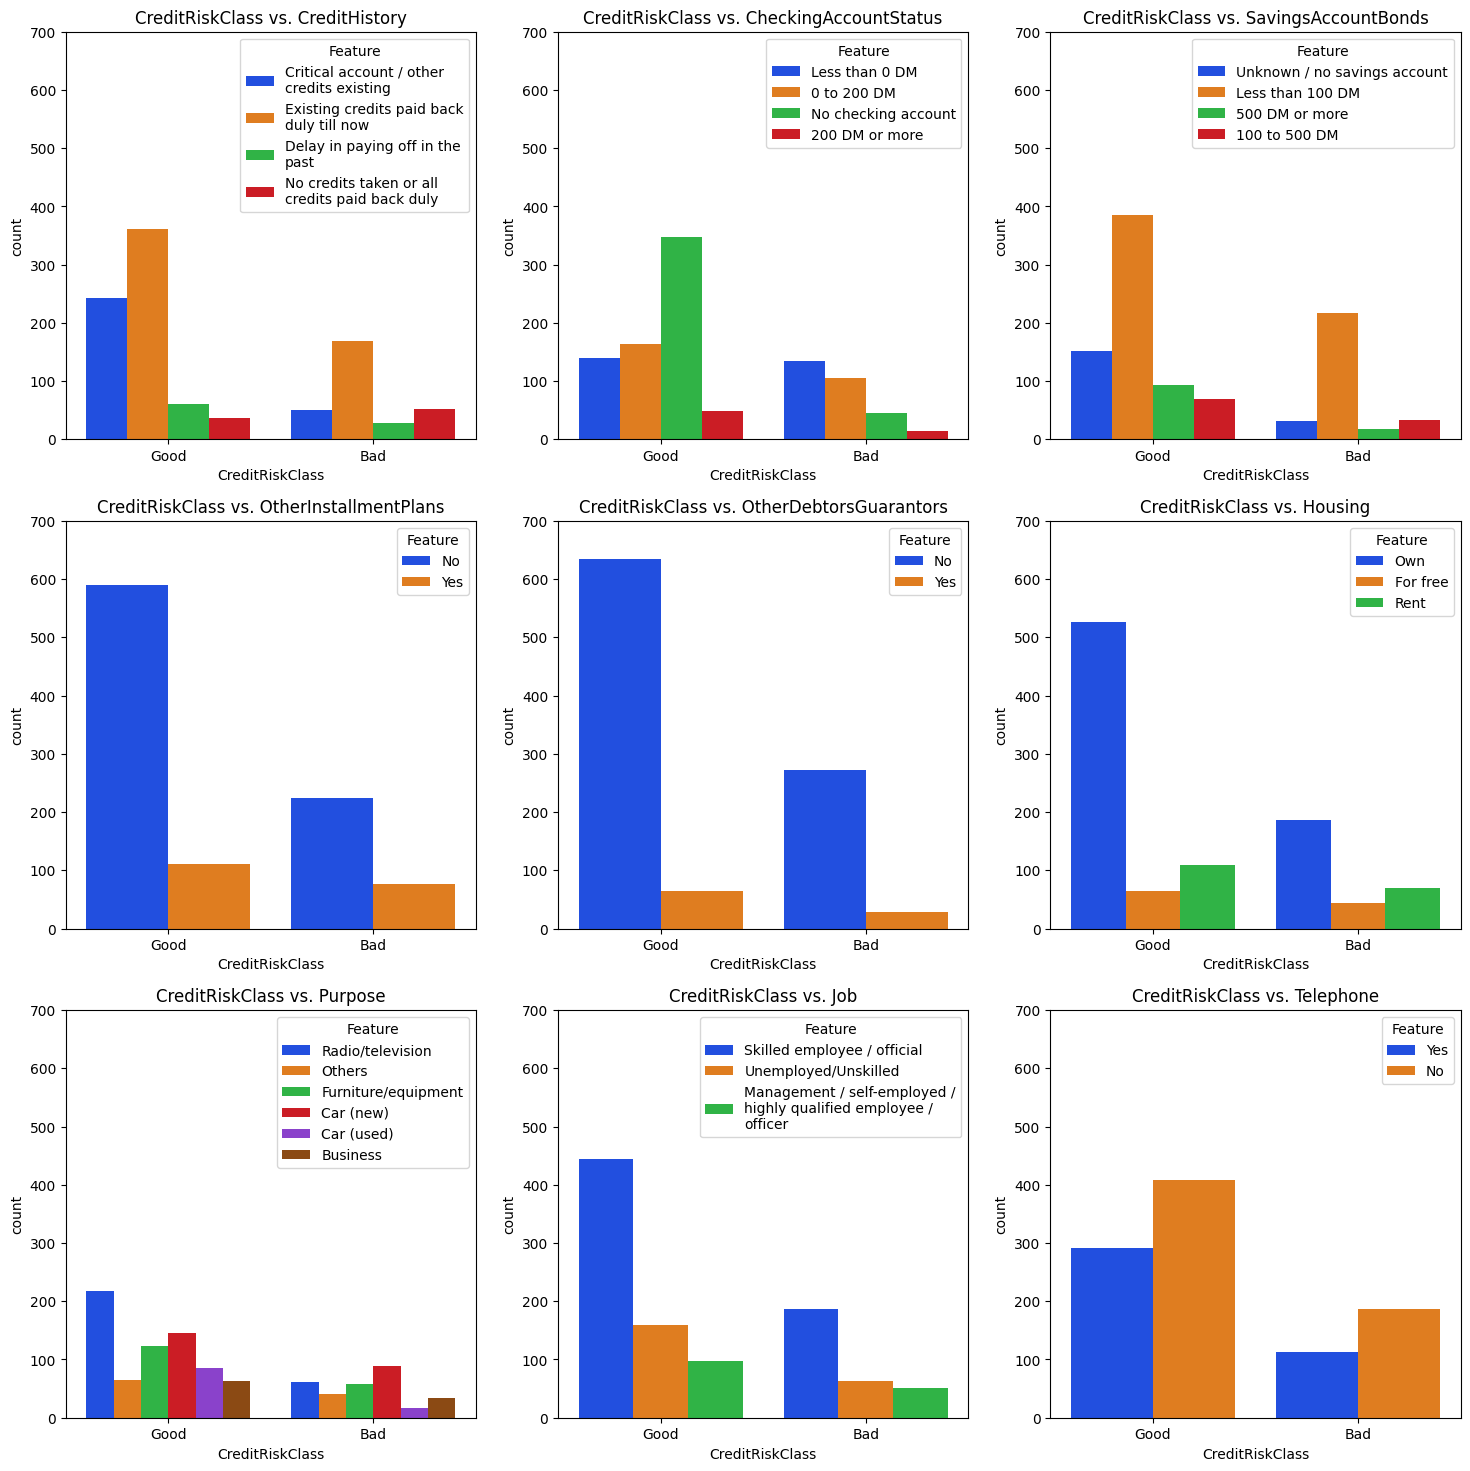

In [88]:
categorical_columns_eda = ["CreditHistory", "CheckingAccountStatus", "SavingsAccountBonds",
                           "OtherInstallmentPlans", "OtherDebtorsGuarantors", "Housing",
                           "Purpose", "Job", "Telephone"]

n_cols = 3
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18,18))

for pos, feature in enumerate(categorical_columns_eda):
    i = pos // 3
    j = pos % 3
    
    ax = axes[i][j]
    
    sns.countplot(ax=ax, x='CreditRiskClass', hue=feature, data=dataset_df, palette="bright")
    ax.set_title(f'CreditRiskClass vs. {feature}')
    
    ax.set_ylim(0, 700)
    
    handles, labels = ax.get_legend_handles_labels()
    new_labels = [break_label(label, 28) for label in labels]  # Apply the function to break labels
    ax.legend(handles, new_labels, title='Feature')
    

**Analysis**

In many of the plots above, such as those for the "Job" and "OtherInstallmentPlans" features, there is no noticeable visual difference between the two target classes in the distribution over the categories. This is further evidenced by the frequency table for the "Job" feature shown below, which indicates that the rate of Good/Bad payers is roughly the same.


In [89]:
create_frequency_table_with_credit_risk(index="Job", df=dataset_df)

CreditRiskClass,Bad,Good,All,P(Bad|Job),P(Good|Job)
Job,,,,,
Management / self-employed / highly qualified employee / officer,51,97,148,0.344595,0.655405
Skilled employee / official,186,444,630,0.295238,0.704762
Unemployed/Unskilled,63,159,222,0.283784,0.716216
All,300,700,1000,0.300000,0.700000


**Analysis**

However, for features such as "CheckingAccountStatus" and "Housing" for example, the difference is notable.
1. CheckingAccountStatus: The concentration of "NoCheckingAccount" in the "CheckingAccountStatus" for the "Good payer" class is much higher.
2. Housing: The disparity between "Own" housing and other categories is much higher in the "Good payer" class

In other cases, such as the "OtherDebtorsGuarantors", the difference is unclear to exist or not.

Therefore, a hypothesis test would be relevant for asserting which features share indeed meaningful to distinguish the "Good" and "Bad" payers populations.

## Hypothesis Test

### Independence test for numerical features ("Age", "DurationInMonths", "CreditAmount")

In [90]:
non_ordinal_numerical_features = ["Age", "DurationInMonths", "CreditAmount"]

dataset_df['CreditRiskClass'] = dataset_df['CreditRiskClass'].astype('category')


categories = dataset_df["CreditRiskClass"].unique()
category_1, category_2 = categories[0], categories[1]


significant_non_ordinal_numerical_features = []

for feature in non_ordinal_numerical_features:
    if pd.api.types.is_numeric_dtype(dataset_df[feature]):
        group1 = dataset_df[dataset_df["CreditRiskClass"] == category_1][feature].dropna()
        group2 = dataset_df[dataset_df["CreditRiskClass"] == category_2][feature].dropna()

        t_stat, p_value = stats.ttest_ind(group1, group2, nan_policy='omit')

        print(f"\nT-test for {feature} vs CreditRiskClass")
        print(f"T-statistic: {t_stat}, P-value: {p_value}")

        if p_value < 0.05:
            print(f"The relationship between {feature} and CreditRiskClass is statistically significant.")
            significant_non_ordinal_numerical_features.append(feature)
        else:
            print(f"The relationship between {feature} and CreditRiskClass is not statistically significant.")

print("\nStatistically significant numerical features:")
print(significant_non_ordinal_numerical_features)



T-test for Age vs CreditRiskClass
T-statistic: 2.890846677564194, P-value: 0.003925339398276282
The relationship between Age and CreditRiskClass is statistically significant.

T-test for DurationInMonths vs CreditRiskClass
T-statistic: -6.9522507242467215, P-value: 6.4880498771843485e-12
The relationship between DurationInMonths and CreditRiskClass is statistically significant.

T-test for CreditAmount vs CreditRiskClass
T-statistic: -4.947965832165981, P-value: 8.797572373528894e-07
The relationship between CreditAmount and CreditRiskClass is statistically significant.

Statistically significant numerical features:
['Age', 'DurationInMonths', 'CreditAmount']


### Chi Square Test for the Categorical Features

In [91]:
ordinal_categorical_features = dataset_df.select_dtypes('int64').columns.drop(["Age", "DurationInMonths", "CreditAmount"]).tolist()

nominal_categorical_features = dataset_df.select_dtypes(include=['object']).columns
nominal_categorical_features = [feature for feature in nominal_categorical_features if feature != 'CreditRiskClass']

categorical_features = ordinal_categorical_features + nominal_categorical_features
significant_categorical_features = []

for feature in categorical_features:
    contingency_table = pd.crosstab(dataset_df[feature], dataset_df['CreditRiskClass'])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)

    print(f"\nChi-Square Test for {feature} vs CreditRiskClass:")
    print(f"H0: There is no association between {feature} and CreditRiskClass.")
    print(f"Ha: There is an association between {feature} and CreditRiskClass.")
    print(f"Chi2 Statistic: {chi2}")
    print(f"P-Value: {p}")
    print(f"Degrees of Freedom: {dof}")

    if round(p,6) < 0.05:
        significant_categorical_features.append(feature)
        print(f"Conclusion: Reject the null hypothesis. The relationship between {feature} and CreditRiskClass is statistically significant.")
    else:
        print(f"Conclusion: Fail to reject the null hypothesis. The relationship between {feature} and CreditRiskClass is not statistically significant.")

print("\nStatistically significant categorical features:")
print(significant_categorical_features)



Chi-Square Test for InstallmentRate vs CreditRiskClass:
H0: There is no association between InstallmentRate and CreditRiskClass.
Ha: There is an association between InstallmentRate and CreditRiskClass.
Chi2 Statistic: 5.476792145153753
P-Value: 0.1400333122128481
Degrees of Freedom: 3
Conclusion: Fail to reject the null hypothesis. The relationship between InstallmentRate and CreditRiskClass is not statistically significant.

Chi-Square Test for ResidenceSince vs CreditRiskClass:
H0: There is no association between ResidenceSince and CreditRiskClass.
Ha: There is an association between ResidenceSince and CreditRiskClass.
Chi2 Statistic: 0.7492964483880512
P-Value: 0.8615521320413175
Degrees of Freedom: 3
Conclusion: Fail to reject the null hypothesis. The relationship between ResidenceSince and CreditRiskClass is not statistically significant.

Chi-Square Test for PeopleLiableMaintenance vs CreditRiskClass:
H0: There is no association between PeopleLiableMaintenance and CreditRiskClas

### Other Hypothesis Tests

Testing if there is a significant difference in the distribution of credit amounts between good and bad credit risk.

H0: The distributions of the feature are the same for both groups.

H1: The distributions of the feature are different for both groups.

In [ ]:
ks_stat, p_val = stats.ks_2samp(good_credit, bad_credit)
print(f"KS-statistic: {ks_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("Conclusion: Reject the null hypothesis. There is a significant difference in the distribution of credit amounts between good and bad credit risk.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is no significant difference in the distribution of credit amounts between good and bad credit risk.")

Testing if there is a significant difference in credit amounts across different CheckingAccountStatus groups.

H0: The mean of the feature is the same for both groups.

H1: The mean of the feature is different for both groups.


In [ ]:
groups = [group['CreditAmount'].values for name, group in dataset_df.groupby('CheckingAccountStatus')]
f_stat, p_val = stats.f_oneway(*groups)
print(f"F-statistic: {f_stat}, P-value: {p_val}")
if p_val < 0.05:
    print("Conclusion: Reject the null hypothesis. There is a significant difference in credit amounts across different CheckingAccountStatus groups.")
else:
    print("Conclusion: Fail to reject the null hypothesis. There is no significant difference in credit amounts across different CheckingAccountStatus groups.")

## Classification Model for Prediction

### Pre-processing

In this part, the dataset is prepared for the training phase.

All non-numerical features are encoded into a numerical representation.

The nominal categorical features are encoded using one-hot code strategy. To avoid multicollinearity, the first one-hot
feature resulting from a nominal categorical  is dropped.

Some ordinal features, such as "EmploymentSince" are given by strings in the original dataset. These ordinal categorical
features are translated to integer numbers appropriately.

The target class "CreditRiskClass" is encoded as follows:
1. "Good": 0
2. "Bad": 1

In [92]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

significant_features = significant_non_ordinal_numerical_features + significant_categorical_features
dataset_model_df = dataset_df[significant_features + ["CreditRiskClass"]]

numerical_cols_to_std = ["Age", "DurationInMonths", "CreditAmount"]

# new ordinal columns to be created, with their respective order of values
ordinal_cols_to_encode = {
    'EmploymentSince': ['Unemployed', 'Less than 1 year', '1 to 4 years', '4 to 7 years', '7 years or more'],
    'CreditRiskClass': ['Good', 'Bad']
}
new_ordinal_cols = list(ordinal_cols_to_encode.keys()) # Name of the new ordinal columns

nominal_cols = [nominal_col for nominal_col in significant_categorical_features if significant_categorical_features != "EmploymentSince"] # Name of the nominal columns

# Encoders to be used in Pre-Processing Pipeline. Here, the first nominal categorical group is dropped to achieve perfect multicollinearity between the predictors
ordinal_encoder = OrdinalEncoder(categories=[ordinal_cols_to_encode[col] for col in new_ordinal_cols])
nominal_onehot_encoder = OneHotEncoder(drop='first')

# Preprocessor for ordinal and nominal features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_to_std), # remove this step if Logistic Regression is not used
        ('ord', ordinal_encoder, new_ordinal_cols),
        ('nom', nominal_onehot_encoder, nominal_cols),
    ])


categorical_cols_encoded = preprocessor.fit_transform(dataset_model_df)

# Get the feature names after one-hot encoding
onehot_col_names = preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_cols)
# Combine with ordinal feature names
categorical_col_encoded_names = (numerical_cols_to_std + new_ordinal_cols + list(onehot_col_names))

# Create a DataFrame with the encoded data
categorical_cols_encoded_df = pd.DataFrame(categorical_cols_encoded, columns=categorical_col_encoded_names)


dataset_encoded_df = dataset_model_df.drop(columns=numerical_cols_to_std + new_ordinal_cols + nominal_cols)
dataset_encoded_df = pd.concat([dataset_encoded_df, categorical_cols_encoded_df], axis=1)

print("New columns: ", dataset_encoded_df.columns)

dataset_encoded_df

New columns:  Index(['Age', 'DurationInMonths', 'CreditAmount', 'EmploymentSince',
       'CreditRiskClass', 'CheckingAccountStatus_200 DM or more',
       'CheckingAccountStatus_Less than 0 DM',
       'CheckingAccountStatus_No checking account',
       'CreditHistory_Delay in paying off in the past',
       'CreditHistory_Existing credits paid back duly till now',
       'CreditHistory_No credits taken or all credits paid back duly',
       'Purpose_Car (new)', 'Purpose_Car (used)',
       'Purpose_Furniture/equipment', 'Purpose_Others',
       'Purpose_Radio/television', 'SavingsAccountBonds_500 DM or more',
       'SavingsAccountBonds_Less than 100 DM',
       'SavingsAccountBonds_Unknown / no savings account',
       'EmploymentSince_4 to 7 years', 'EmploymentSince_7 years or more',
       'EmploymentSince_Less than 1 year', 'EmploymentSince_Unemployed',
       'Property_Car or other', 'Property_Real estate',
       'Property_Unknown / no property', 'OtherInstallmentPlans_Yes',
  

,Age,DurationInMonths,CreditAmount,EmploymentSince,CreditRiskClass,CheckingAccountStatus_200 DM or more,CheckingAccountStatus_Less than 0 DM,CheckingAccountStatus_No checking account,CreditHistory_Delay in paying off in the past,CreditHistory_Existing credits paid back duly till now,...,EmploymentSince_4 to 7 years,EmploymentSince_7 years or more,EmploymentSince_Less than 1 year,EmploymentSince_Unemployed,Property_Car or other,Property_Real estate,Property_Unknown / no property,OtherInstallmentPlans_Yes,Housing_Own,Housing_Rent
0,2.766456,-1.236478,-0.745131,4.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.191404,2.248194,0.949817,2.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.183312,-0.738668,-0.416562,3.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.831502,1.750384,1.634247,3.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.535122,0.256953,0.566664,2.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.399832,-0.738668,-0.544162,3.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
996,0.391740,0.754763,0.207612,2.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
997,0.215835,-0.738668,-0.874503,4.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
998,-1.103451,1.999289,-0.505528,2.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


#### Data-Splitting

The original dataset was split into training/testing set using the traditional ratio 80%/20%.

As the dataset is considerably unbalanced for the target class, the target column "CreditRiskClass" was used for the stratification strategy. This means that 
both the training and testing sets have a similar distribution of the target classes as the original dataset (70%/30%).

In [93]:
from sklearn.model_selection import train_test_split

features_encoded_df = dataset_encoded_df.drop(columns="CreditRiskClass")
target_class = dataset_encoded_df["CreditRiskClass"]

X_train, X_test, y_train, y_test = train_test_split(features_encoded_df, target_class,
                                                    stratify=target_class,
                                                    train_size=0.8,
                                                    random_state=123)

print("Training set size: ",len(X_train))
print("Test set size: ", len(X_test))

Training set size:  800
Test set size:  200


### Random Forest

In [94]:
from sklearn.ensemble import RandomForestClassifier

base_model_rf = RandomForestClassifier(random_state=123)

In [95]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

# Special metric for the classification cross validation. The idea is to find the best
# hyperparameters which minimize the cost given by the cost matrix of the problem,
# which penalizes more false negatives as false positives
cost_scorer = make_scorer(cost_metric, greater_is_better=False) 

# Define hyperparameters to tune
param_grid = {
    "n_estimators": [10, 25, 50, 75, 100],
    "max_depth": [None, 10, 20, 25],
    "min_samples_split": [2, 5, 10, 20]
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

base_model_rf_gridcv = GridSearchCV(base_model_rf, param_grid, scoring=cost_scorer, cv=cv)

base_model_rf_gridcv.fit(X_train, y_train)

best_rf_gridcv = base_model_rf_gridcv.best_estimator_

base_model_rf_gridcv.best_params_

{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 25}

In [96]:
from sklearn.model_selection import TunedThresholdClassifierCV

# The threshold probability for the classification is determined via cross-validation to minimize the false 
# negative rate according to the cost matrix of the problem
model_rf_threshold_cv = TunedThresholdClassifierCV(best_rf_gridcv, scoring=cost_scorer,
                                                   store_cv_results=True, random_state=123)

model_rf_threshold_cv.fit(X_train, y_train)

TunedThresholdClassifierCV(estimator=RandomForestClassifier(max_depth=20,
                                                            n_estimators=25,
                                                            random_state=123),
                           random_state=123,
                           scoring=make_scorer(cost_metric, greater_is_better=False, response_method='predict'),
                           store_cv_results=True)

In [97]:
print("Best threshold for Cost Matrix: ", model_rf_threshold_cv.best_threshold_)

Best threshold for Cost Matrix:  0.1672727272727273


#### Performance Analysis - Random Forest

##### Results for Case without Threshold Tunning - Random Forest

              precision    recall  f1-score   support

        Good       0.80      0.89      0.84       140
         Bad       0.66      0.48      0.56        60

    accuracy                           0.77       200
   macro avg       0.73      0.69      0.70       200
weighted avg       0.76      0.77      0.76       200

Cost Metric:  170


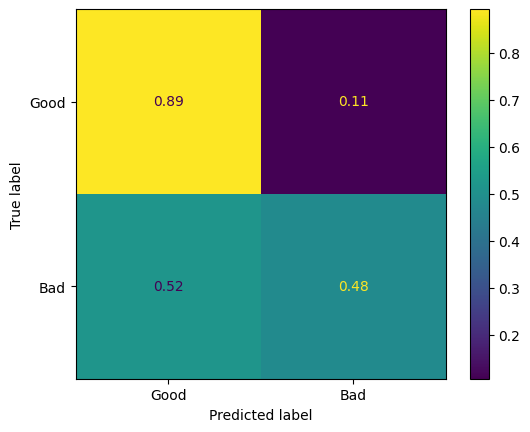

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


y_pred_no_threshold_tunning = best_rf_gridcv.predict(X_test)

print(classification_report(y_test, y_pred_no_threshold_tunning, target_names=["Good", "Bad"]))

cost_metric_no_threshold_tunning = cost_metric(y_test, y_pred_no_threshold_tunning)

print("Cost Metric: ", cost_metric_no_threshold_tunning)

ConfusionMatrixDisplay.from_estimator(best_rf_gridcv, X_test, y_test, normalize="true", display_labels=["Good", "Bad"])

##### Results for Case with Threshold Tunning - Random Forest

              precision    recall  f1-score   support

        Good       0.89      0.46      0.61       140
         Bad       0.41      0.87      0.56        60

    accuracy                           0.58       200
   macro avg       0.65      0.67      0.58       200
weighted avg       0.75      0.58      0.59       200

Cost Metric:  115


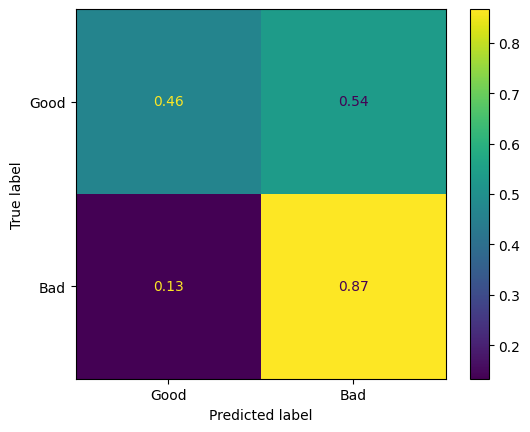

In [99]:
y_pred = model_rf_threshold_cv.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Good", "Bad"]))

print("Cost Metric: ", cost_metric(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(model_rf_threshold_cv, X_test, y_test, normalize="true", display_labels=["Good", "Bad"])

#### ROC Curve - Random Forest

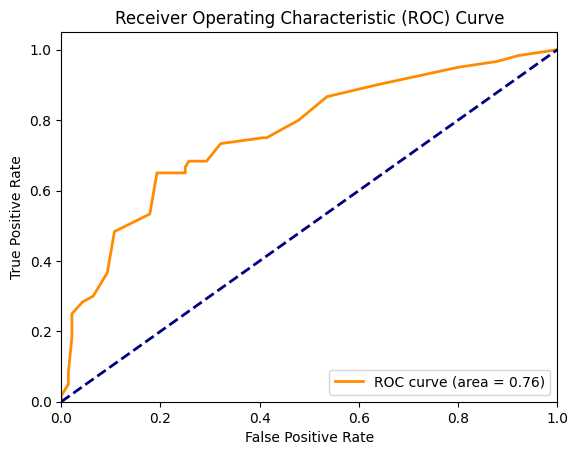

In [100]:
from sklearn.metrics import roc_curve, roc_auc_score

# Probabilities of test samples to belong to class "Bad Payers = High Risk". This is equal for both models
y_probs = model_rf_threshold_cv.predict_proba(X_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

roc_auc = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [101]:
from sklearn.linear_model import LogisticRegressionCV

base_model_lr = LogisticRegressionCV(cv=cv, random_state=123, scoring=cost_scorer)

base_model_lr.fit(X_train, y_train)

base_model_lr.get_params()

{'Cs': 10,
 'class_weight': None,
 'cv': StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 123,
 'refit': True,
 'scoring': make_scorer(cost_metric, greater_is_better=False, response_method='predict'),
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0}

In [102]:
model_lr_threshold_cv = TunedThresholdClassifierCV(base_model_lr, scoring=cost_scorer, store_cv_results=True)

model_lr_threshold_cv.fit(X_train, y_train)

print("Best threshold for Cost Matrix: ", model_lr_threshold_cv.best_threshold_)

Best threshold for Cost Matrix:  0.19252975303536782


#### Performance Analysis - Logistic Regression

##### Results for Case without Threshold Tunning - Logistic Regression

              precision    recall  f1-score   support

        Good       0.78      0.86      0.82       140
         Bad       0.57      0.43      0.49        60

    accuracy                           0.73       200
   macro avg       0.67      0.65      0.65       200
weighted avg       0.72      0.73      0.72       200

Cost Metric:  190


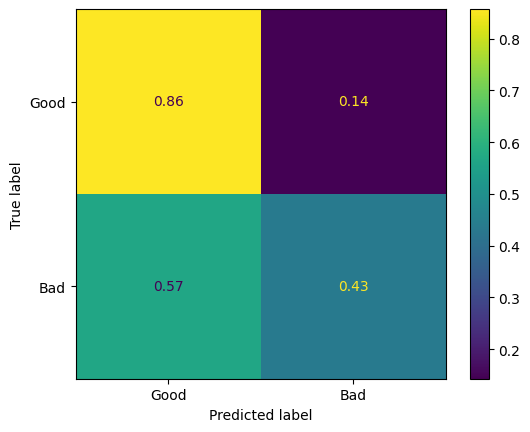

In [103]:
y_pred_without_threshold_cv = base_model_lr.predict(X_test)

print(classification_report(y_test, y_pred_without_threshold_cv, target_names=["Good", "Bad"]))

print("Cost Metric: ", cost_metric(y_test, y_pred_without_threshold_cv))

ConfusionMatrixDisplay.from_estimator(base_model_lr, X_test, y_test, normalize="true", display_labels=["Good", "Bad"])

##### Results for Case with Threshold Tunning - Logistic Regression

              precision    recall  f1-score   support

        Good       0.85      0.49      0.62       140
         Bad       0.40      0.80      0.53        60

    accuracy                           0.58       200
   macro avg       0.62      0.64      0.58       200
weighted avg       0.71      0.58      0.59       200

Cost Metric:  132


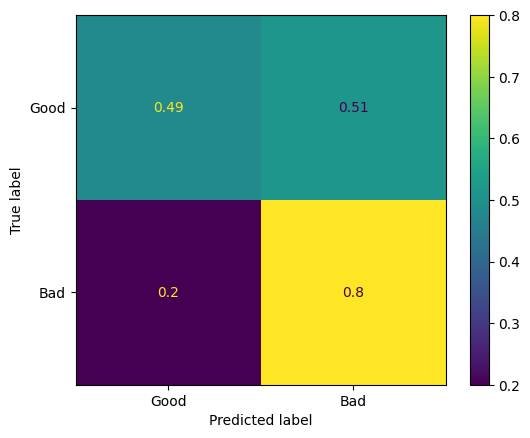

In [104]:
y_pred = model_lr_threshold_cv.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Good", "Bad"]))

print("Cost Metric: ", cost_metric(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(model_lr_threshold_cv, X_test, y_test, normalize="true", display_labels=["Good", "Bad"])

#### ROC Curve - Logistic Regression

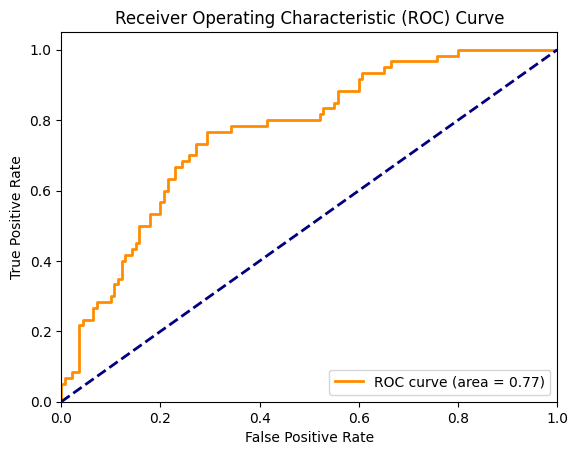

In [105]:
y_probs = base_model_lr.predict_proba(X_test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

roc_auc = roc_auc_score(y_test, y_probs)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Conclusion

## Citation